# Lesson 3: sMRI Spatial Normalization

## Objectives
- Visualize templates and understand registration process

## Python Requirements
- [matplotlib](https://matplotlib.org/)
- [nibabel](https://nipy.org/nibabel/)
- [nilearn](https://nilearn.github.io/index.html)

## Useful resources:
- FreeSurfer output [description](https://surfer.nmr.mgh.harvard.edu/fswiki/ReconAllTableStableV5.3)
- Nipype [snippets](https://miykael.github.io/nipype_tutorial/)

## Dataset used:
- [AOMIC](https://nilab-uva.github.io/AOMIC.github.io/): the Amsterdam Open MRI [Collection](https://openneuro.org/datasets/ds002790/versions/2.0.0)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import nilearn
from nilearn import datasets
from nilearn import plotting
from nilearn import image
from nibabel.affines import apply_affine
import os
from bids import BIDSLayout

## Dataset

### Here we will be using a subset of [AOMIC](https://nilab-uva.github.io/AOMIC.github.io/): the Amsterdam Open MRI Collection from [OpenNeuro](https://openneuro.org/datasets/ds002790/versions/2.0.0).

<img src="../fig/episode_2/AOMIC_openneuro.png" width="1000">

## The anatomical data along with the processed derivatives are conveninetly organized in BIDS format! 

|      Scans  | fMRIPrep Output | FreeSurfer Output |
| :-------------: | :-----------: |:-----------: |
| <img src="../fig/episode_2/AOMIC_BIDS_level_1.png" width="500"> | <img src="../fig/episode_2/AOMIC_BIDS_fmriprep.png" width="420"> |  <img src="../fig/episode_2/AOMIC_BIDS_level_2.png" width="415"> |



## We have already downloaded data for 'sub-0001' or 'sub-0002' in the local_data/AOMIC directory. 

### If you would like to try with more subjects you can use "aws" commands below to download more subjects either in the terminal or in the notebook. This can be slow depending on how much data you are downloading / Binder instance / local internet connection. Beware the derivative files (i.e. processed output) can be huge. 


In [2]:
### Uncomment line below to download anatomical subject data for sub-0003
# !aws s3 sync --no-sign-request s3://openneuro.org/ds002790 ../local_data/AOMIC/ --exclude "*" --include "sub-0003/anat/*"

### Uncomment line below to download freesurfer subject data for sub-0003
# !aws s3 sync --no-sign-request s3://openneuro.org/ds002790 ../local_data/AOMIC/ --exclude "*" --include "derivatives/freesurfer/sub-0003/mri/*"


## Local paths

In [3]:
local_data_dir = '../local_data/'
bids_data_dir = '../local_data/AOMIC'

bids_layout = BIDSLayout(bids_data_dir, derivatives=True)

subject_id = 'sub-0001' # pick 'sub-0001' or 'sub-0002'

freesurfer_output_dir = local_data_dir + 'AOMIC/derivatives/freesurfer/{}/mri/'.format(subject_id)
fsaverage_dir = local_data_dir +  'AOMIC/derivatives/freesurfer/fsaverage5/mri/'

print('Using {}'.format(subject_id))

/home/nikhil/anaconda3/envs/parkinsons/lib/python3.8/site-packages/bids/layout/models.py:148: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "
Using sub-0001


## Templates and atlases
We are grabbing these from [nilearn datasets](https://nilearn.github.io/manipulating_images/input_output.html#datasets)

### ICBM152_2009 template/atlas

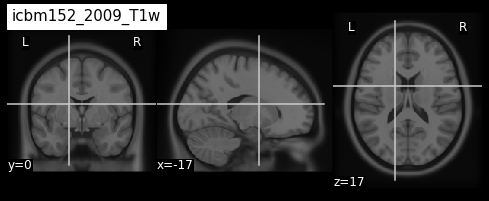

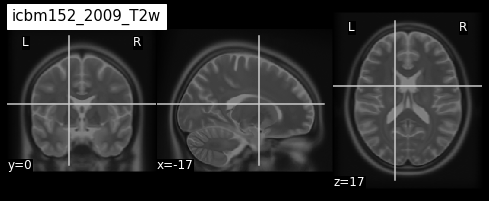

In [4]:
atlas = datasets.fetch_icbm152_2009()
cut_coords = (-17,0,17)
atlas_t1 = atlas["t1"]
atlas_t1_img = nib.load(atlas_t1)

atlas_t2 = atlas["t2"]
atlas_t2_img = nib.load(atlas_t2)

plotting.plot_anat(atlas_t1_img, title="icbm152_2009_T1w", cut_coords=cut_coords, vmax=200)
plotting.plot_anat(atlas_t2_img, title="icbm152_2009_T2w", cut_coords=cut_coords, vmax=200)

## Subject (native) space vs template (reference) space 

### Question: Do the x,y,z coordinates for "subject space" vs. "template space" map to the same location in the brain? 


### fMRIPrep Example

Text(0.5, 1.0, 'MNI reference space')

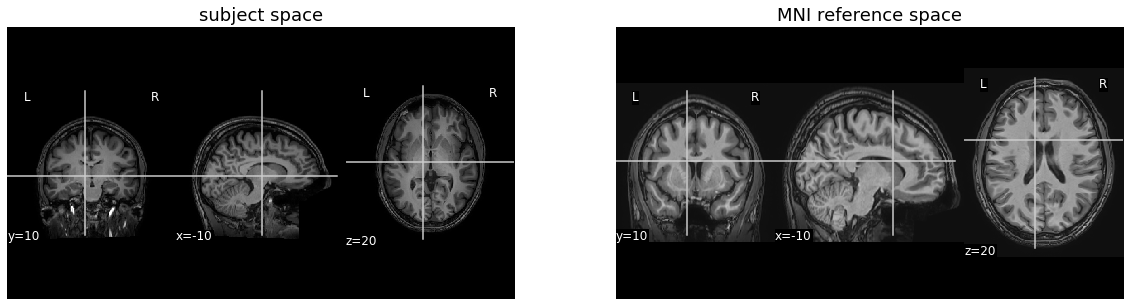

In [5]:
cut_coords = (-10,10,20)

subject_T1 = bids_layout.get(subject="0001", datatype='anat', scope='raw',
                            extension='nii.gz', return_type='filename')[0]

subject_T1_MNI_space = bids_layout.get(subject="0001", scope="derivatives", datatype='anat', suffix='T1w', 
                               space='MNI152NLin2009cAsym', desc='preproc', extension='nii.gz', return_type='filename')[0]

# plot
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,5))
ax=axes[0]
vmax = 0.6*nib.load(subject_T1).get_fdata().max() #adjust brightness
plotting.plot_anat(subject_T1, title="", cut_coords=cut_coords, vmax=vmax, axes=ax)
ax.set_title('subject space', fontsize=18)

ax=axes[1]
vmax = 0.6*nib.load(subject_T1_MNI_space).get_fdata().max() #adjust brightness
plotting.plot_anat(subject_T1_MNI_space, title="", cut_coords=cut_coords,vmax=vmax, axes=ax)
ax.set_title('MNI reference space', fontsize=18)                 

## Q: How do get the mapping between these two coordinate spaces? 
## A: Registration transforms! 

### fMRIPrep outputs two transforms
#### T1w to MNI space: *T1w_target-MNI152NLin2009cAsym_warp.h5 Composite (warp and affine) 
#### MNI to T1 space: *T1w_space-MNI152NLin2009cAsym_target-T1w_warp.h5 Composite (warp and affine) 


### FreeSurfer example

Text(0.5, 1.0, 'fsaverage reference space')

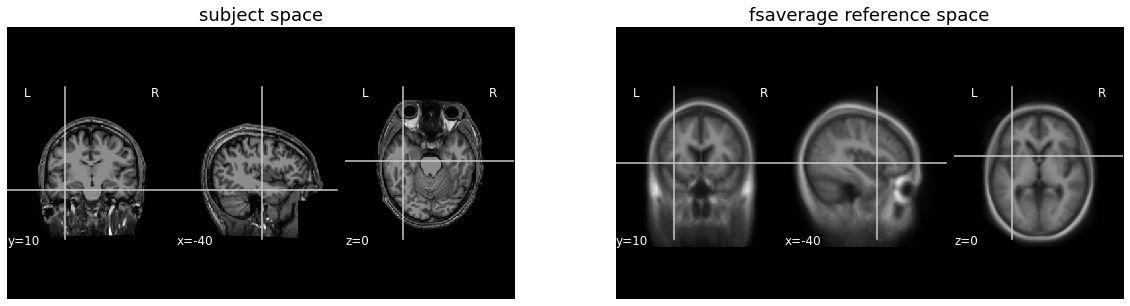

In [6]:
cut_coords = (-40,10,0)

# subject image
subject_T1 = freesurfer_output_dir + 'T1.mgz'

# fsaverage image
fsaverage_T1 = fsaverage_dir + "T1.mgz"

# plot
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,5))
ax=axes[0]
plotting.plot_anat(subject_T1, title="", cut_coords=cut_coords, vmax=200, axes=ax)
ax.set_title('subject space', fontsize=18)

ax=axes[1]
plotting.plot_anat(fsaverage_T1, title="", cut_coords=cut_coords, vmax=200, axes=ax)
ax.set_title('fsaverage reference space', fontsize=18)

## How do we map a point-location (cross-hairs) from subject space to the reference space? 
- Use affine transform from the registration (for freesurfer: 'sub-0001/mri/transforms/talairach.xfm')

Subject space to refernce space mapping:
 (-40, 10, 0) --> (-41,-18,-21)




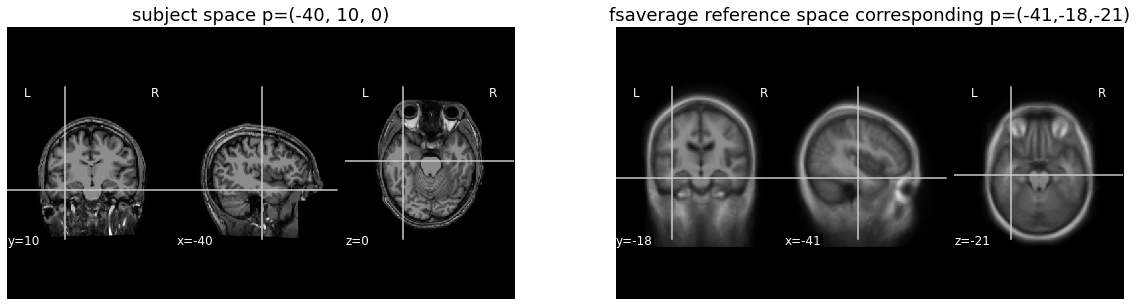

In [8]:
A = np.array([[1.027387, -0.011288, 0.022386, -0.672699],
              [-0.013200, 1.032273, 0.177898, -29.044456],
              [-0.052202, -0.149410, 1.149998, -22.219437],
              [0. ,0. , 0., 1.]])

cut_coords_affine_transformed = apply_affine(A, cut_coords)
x,y,z = cut_coords_affine_transformed
cut_coords_affine_transformed_str = "({},{},{})".format(int(x),int(y),int(z))

print("Subject space to refernce space mapping:\n {} --> {}\n\n".format(cut_coords,cut_coords_affine_transformed_str))
# plot
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,5))
ax=axes[0]
plotting.plot_anat(subject_T1, title="", cut_coords=cut_coords, vmax=200, axes=ax)
ax.set_title('subject space p={}'.format(cut_coords), fontsize=18)

ax=axes[1]
plotting.plot_anat(fsaverage_T1, title="", cut_coords=cut_coords_affine_transformed, vmax=200, axes=ax)
ax.set_title('fsaverage reference space corresponding p={}'.format(cut_coords_affine_transformed_str), fontsize=18);